<a href="https://colab.research.google.com/github/UKJaagadhep/Data-science-and-machine-learning/blob/main/Intent%20Classification%20with%20DeBERTa/Intent_Classification_with_DeBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.2 MB/s eta 0:00:00


In [34]:
from datasets import load_dataset
from transformers import DebertaV2TokenizerFast, TFDebertaV2ForSequenceClassification
from transformers import DebertaTokenizerFast, TFDebertaForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import create_optimizer
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

# **DATA PREPARATION**

In [3]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d bitext/training-dataset-for-chatbotsvirtual-assistants
!unzip "/content/training-dataset-for-chatbotsvirtual-assistants.zip" -d "/content/dataset/"

Dataset URL: https://www.kaggle.com/datasets/bitext/training-dataset-for-chatbotsvirtual-assistants
License(s): copyright-authors
 86% 1.00M/1.16M [00:00<00:00, 3.54MB/s]
100% 1.16M/1.16M [00:00<00:00, 3.98MB/s]
Archive:  /content/training-dataset-for-chatbotsvirtual-assistants.zip
  inflating: /content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.csv  
  inflating: /content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.xlsx  
  inflating: /content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assist

In [4]:
dataset = load_dataset("csv", data_files = ["/content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.csv"])

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['flags', 'utterance', 'category', 'intent'],
        num_rows: 21534
    })
})

In [6]:
dataset['train'][0:3]

{'flags': ['BILC', 'BILQZ', 'BPLC'],
 'utterance': ["I don't have an online account, what do I have to do to register?",
  'can you tell me if i can regisger two accounts with a single email address?',
  'I have no online account, open one, please'],
 'category': ['ACCOUNT', 'ACCOUNT', 'ACCOUNT'],
 'intent': ['create_account', 'create_account', 'create_account']}

In [7]:
batch_size = 16

In [8]:
intents = list(set(dataset['train']['intent'])) #To get the unique intent names
dict_intents = {intents[i] : i for i in range(len(intents))} #mapping each intent to an integer label
dict_intents

{'check_cancellation_fee': 0,
 'get_invoice': 1,
 'get_refund': 2,
 'track_refund': 3,
 'delete_account': 4,
 'contact_human_agent': 5,
 'set_up_shipping_address': 6,
 'check_payment_methods': 7,
 'switch_account': 8,
 'check_refund_policy': 9,
 'check_invoices': 10,
 'recover_password': 11,
 'edit_account': 12,
 'delivery_period': 13,
 'create_account': 14,
 'newsletter_subscription': 15,
 'change_order': 16,
 'review': 17,
 'complaint': 18,
 'place_order': 19,
 'contact_customer_service': 20,
 'cancel_order': 21,
 'payment_issue': 22,
 'change_shipping_address': 23,
 'registration_problems': 24,
 'delivery_options': 25,
 'track_order': 26}

In [9]:
def preprocess(dataset):
  return {'utterance' : dataset['utterance'],
          'intent' : dict_intents[dataset['intent']]}

In [10]:
prep_dataset = dataset.map(preprocess)

Map:   0%|          | 0/21534 [00:00<?, ? examples/s]

In [11]:
prep_dataset['train'][0 : 3]

{'flags': ['BILC', 'BILQZ', 'BPLC'],
 'utterance': ["I don't have an online account, what do I have to do to register?",
  'can you tell me if i can regisger two accounts with a single email address?',
  'I have no online account, open one, please'],
 'category': ['ACCOUNT', 'ACCOUNT', 'ACCOUNT'],
 'intent': [14, 14, 14]}

In [36]:
model_id = "microsoft/deberta-base"
tokenizer = DebertaTokenizerFast.from_pretrained(model_id)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [37]:
def tokenizer_function(dataset):
  return tokenizer(dataset["utterance"])

In [38]:
tokenized_dataset = prep_dataset.map(tokenizer_function)

Map:   0%|          | 0/21534 [00:00<?, ? examples/s]

In [39]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['flags', 'utterance', 'category', 'intent', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 21534
    })
})

In [40]:
tokenized_dataset['train'][0 : 3]

{'flags': ['BILC', 'BILQZ', 'BPLC'],
 'utterance': ["I don't have an online account, what do I have to do to register?",
  'can you tell me if i can regisger two accounts with a single email address?',
  'I have no online account, open one, please'],
 'category': ['ACCOUNT', 'ACCOUNT', 'ACCOUNT'],
 'intent': [14, 14, 14],
 'input_ids': [[1,
   100,
   218,
   75,
   33,
   41,
   804,
   1316,
   6,
   99,
   109,
   38,
   33,
   7,
   109,
   7,
   5124,
   116,
   2],
  [1,
   7424,
   47,
   1137,
   162,
   114,
   939,
   64,
   6701,
   354,
   2403,
   80,
   2349,
   19,
   10,
   881,
   1047,
   1100,
   116,
   2],
  [1, 100, 33, 117, 804, 1316, 6, 490, 65, 6, 2540, 2]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [41]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = "tf")

In [42]:
tf_dataset = tokenized_dataset["train"].to_tf_dataset( #to_tf_dataset() method already has prefetch
    columns = ['input_ids','attention_mask', 'intent'],
    shuffle = True,
    batch_size = batch_size,
    collate_fn = data_collator
)

In [43]:
def swap_positions(dataset):
  return {'input_ids' : dataset['input_ids'],
          'attention_mask' : dataset['attention_mask']}, dataset['intent']

In [44]:
tf_dataset = tf_dataset.map(swap_positions)

In [45]:
train_dataset = tf_dataset.take(int(0.9 * len(tf_dataset)))
val_dataset = tf_dataset.skip(int(0.9 * len(tf_dataset)))

In [46]:
for i in val_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(16, 26), dtype=int64, numpy=
array([[    1,  9178,   109,    38,  6296,     9,  1272,   442,    10,
         3207,   116,     2,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [    1,  9178,   109,    38,  1649,     5,  1735,    13,  3682,
         2996,   116,     2,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [    1,   118,   399,    75,  1325,   127, 12259,   139,  6355,
            6,   115,  1717,  1217,   106,     6,  2540,   116,     2,
            0,     0,     0,     0,     0,     0,     0,     0],
       [    1,   118,   236,    41,  1316,     6,   939,   240,   244,
         1273,    65,     2,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0],
       [    1,   100,   300,    41,  5849,  1579,    77,    38,  3751,
            7,   582,     6,    53,   

# **MODELING (TFDebertaForSequenceClassification)**

In [47]:
model = TFDebertaForSequenceClassification.from_pretrained(model_id, num_labels = len(intents))
model.summary()

tf_model.h5:   0%|          | 0.00/555M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaForSequenceClassification.

Some layers of TFDebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler', 'classifier', 'cls_dropout']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_deberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 deberta (TFDebertaMainLaye  multiple                  138601728 
 r)                                                              
                                                                 
 pooler (TFDebertaContextPo  multiple                  590592    
 oler)                                                           
                                                                 
 cls_dropout (TFDebertaStab  multiple                  0         
 leDropout)                                                      
                                                                 
 classifier (Dense)          multiple                  20763     
                                                                 
Total params: 139213083 (531.06 MB)
Trainable params: 139213083 (531.06 MB)
Non-trainable para

# **TRAINING**

In [48]:
num_epochs = 6
batches_per_epoch = len(tokenized_dataset["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

In [49]:
optimizer, schedule = create_optimizer(init_lr = 2e-5, num_warmup_steps = 0, num_train_steps = total_train_steps)

In [53]:
model.compile(optimizer = optimizer, metrics = ["accuracy"],
              #run_eagerly = True
              )

In [54]:
history = model.fit(
    train_dataset.take(100),
    validation_data = val_dataset.take(20),
    epochs = num_epochs)

Epoch 1/6
100/100 [==============================] - 146s 532ms/step - loss: 1.9700 - accuracy: 0.5238 - val_loss: 0.5341 - val_accuracy: 0.9187
Epoch 2/6
100/100 [==============================] - 29s 291ms/step - loss: 0.3336 - accuracy: 0.9550 - val_loss: 0.1128 - val_accuracy: 0.9812
Epoch 3/6
100/100 [==============================] - 28s 282ms/step - loss: 0.1245 - accuracy: 0.9825 - val_loss: 0.0563 - val_accuracy: 1.0000
Epoch 4/6
100/100 [==============================] - 32s 322ms/step - loss: 0.0718 - accuracy: 0.9900 - val_loss: 0.0310 - val_accuracy: 0.9969
Epoch 5/6
100/100 [==============================] - 27s 274ms/step - loss: 0.0425 - accuracy: 0.9969 - val_loss: 0.0320 - val_accuracy: 0.9937
Epoch 6/6
100/100 [==============================] - 28s 277ms/step - loss: 0.0388 - accuracy: 0.9937 - val_loss: 0.0242 - val_accuracy: 0.9937


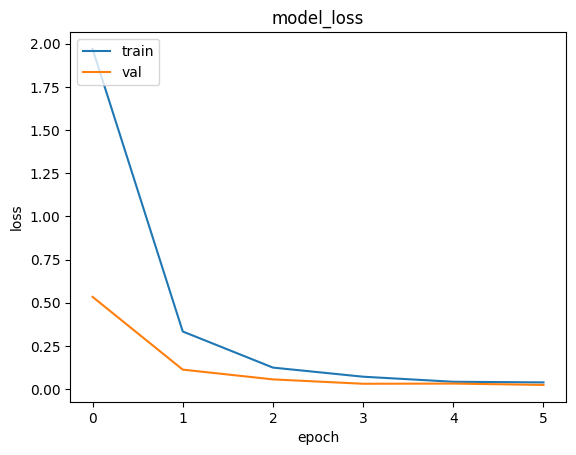

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

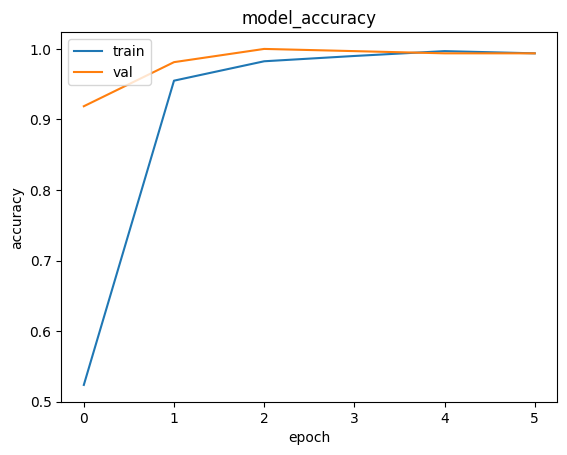

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

# **EVALUATION (CONFUSION MATRIX)**

In [57]:
predicted = []
labels = []

for input, label in val_dataset.take(20):
  predicted.append(model(**input).logits)
  labels.append(label.numpy())

In [58]:
print(predicted)
print(labels)

[<tf.Tensor: shape=(16, 27), dtype=float32, numpy=
array([[-1.70874279e-02, -7.22544789e-01, -1.23536408e+00,
        -1.19276714e+00, -9.80928659e-01, -4.00165886e-01,
        -1.48492610e+00,  2.37125665e-01,  7.73216411e-02,
        -3.15878838e-01, -1.22751498e+00, -1.21516740e+00,
         1.20383412e-01, -6.31935656e-01, -9.20570970e-01,
        -9.87246335e-01,  8.29054165e+00,  1.05222833e+00,
        -1.06682611e+00,  4.01553333e-01, -4.99088950e-02,
        -3.26734900e-01, -2.70287395e-01,  2.37499312e-01,
        -9.23848689e-01,  3.49696651e-02,  4.16031294e-02],
       [-3.51450711e-01, -7.97630131e-01, -3.61824274e-01,
        -1.08252740e+00, -7.70077825e-01, -1.50632358e+00,
        -4.85799283e-01,  2.69638568e-01, -3.00159037e-01,
        -1.23555505e+00,  2.26215005e-01,  6.67039454e-02,
        -9.68547821e-01, -1.27961302e+00, -1.97470263e-01,
        -5.65792024e-01, -9.16541755e-01,  2.29934871e-01,
         5.73372543e-01, -1.12563515e+00,  2.70433426e-01,
    

In [59]:
print(tf.argmax(predicted[: -1], axis = -1).numpy())
print(labels[: -1])

[[16 22 25 20 18 22 22  2  7 25 14 22  7 20 22 22]
 [19  4 22 14 14 22  1 17 22 25 20 22  9  2 22 20]
 [14 16 14 18  4  1 22 14 22 20 22 16 26 14  2 22]
 [22 22  8  5 26 11 16  1 20  8 20  5  2 22  2 11]
 [20 20 17 22 22 11 22  9 10  1 15 22 10 20  2 22]
 [10 22  2 14 22  4 20 22 22  2 14 11 11 14 14 20]
 [18 26  2  5 20 25  5 23 22  9  5  2 22  2 22 14]
 [ 2 22  0  7  2 18 11 20  8  2 20 22  3 20 22  4]
 [22 12  9  9 22 20 22  0 20 10 26 22 22  9 22 14]
 [16 22  5 14  1  5  8 14 14 26 22  1 25  2 20 10]
 [16 23  4 20 25 14 22 22  8 22 14 22 22  1 11 20]
 [14 11  3 14 17 12 14  5 22 11 26 14 26 22 22 11]
 [ 5  1 22 14 22 20 20 22 18  9  1 14 25 14 20  0]
 [10 18 22 14 22 10  0  4  5  3 10 26 18  1  7 14]
 [24  5 22 26  9  1 17  9 20 16 17  2 22 11 18 10]
 [ 5 18 10  2  3 14  0 14 16  1 22  1 17 10  1 16]
 [22  2 20 16 22 22 16  7 22 20 22 20 17  8 26 22]
 [22  8 14 20 22 18 18 22 14  5 11 22 22 14 24 22]
 [22  7 17 22 22 22 14  9 20  2 26 22 26 18 14 22]]
[array([16, 22, 25, 20, 18, 22

In [60]:
print(np.concatenate([np.array(labels[: -1]).flatten(), np.array(labels[-1]).flatten()]))
print(np.concatenate([np.argmax(predicted[: -1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[16 22 25 20 18 22 22  2  7 25 14 22  7 20 22 22 19  4 22 14 14 22  1 17
 22 25 20 22  2  2 22 20 14 16 14 18  4  1 22 14 22 20 22 16 26 14  2 22
 22 22  8  5 26 11 16  1 20  8 20  5  2 22  2 11 20 20 17 22 22 11 22  9
 10  1 15 22 10 20  2 22 10 22  2 14 22  4 20 22 22  2 14 11 11 14 14 20
 18 26  2  5 20 25  5 23 22  9  5  2 22  2 22 14  2 22  0  7  2 18 11 20
  8  2 20 22  3 20 22  4 22 12  9  9 22 20 22  0 20 10 26 22 22  9 22 14
 16 22  5 14  1  5  8 14 14 26 22  1 25  2 20 10 16 23  4 20 25 14 22 22
  8 22 14 22 22  1 11 20 14 11  3 14 17 12 14  5 22 11 26 14 26 22 22 11
  5  1 22 14 22 20 20 22 18  9  1 14 25 14 20  0 10 18 22 14 22 10  0  4
  5  3 10 26 18  1  7 14 24  5 22 26  9  1 17  9 20 16 17  2 22 11 18 10
  5 18 10  2  3 14  0 14 16  1 22  1 17 10  1 16 22  2 20 16 22 22 16  7
 22 20 22 20 17  8 26 22 22  8 14 20 22 18 18 22 14  5 11 22 22 14 24 22
 22  7 17 22 22 22 14  9 20  2 26 22 26 18 14 22 14 20 20 20 11 22  1  2
  7 22 16 25  5 26 22 11]
[16 22 25 20 18 22 22  2 

In [61]:
pred = np.concatenate([np.array(labels[: -1]).flatten(),np.array(labels[-1]).flatten()])
lab = np.concatenate([np.argmax(predicted[: -1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])

In [63]:
cm = confusion_matrix(lab, pred)
print(cm)

[[ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 35  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0

Text(0.5, 146.7222222222222, 'Predicted')

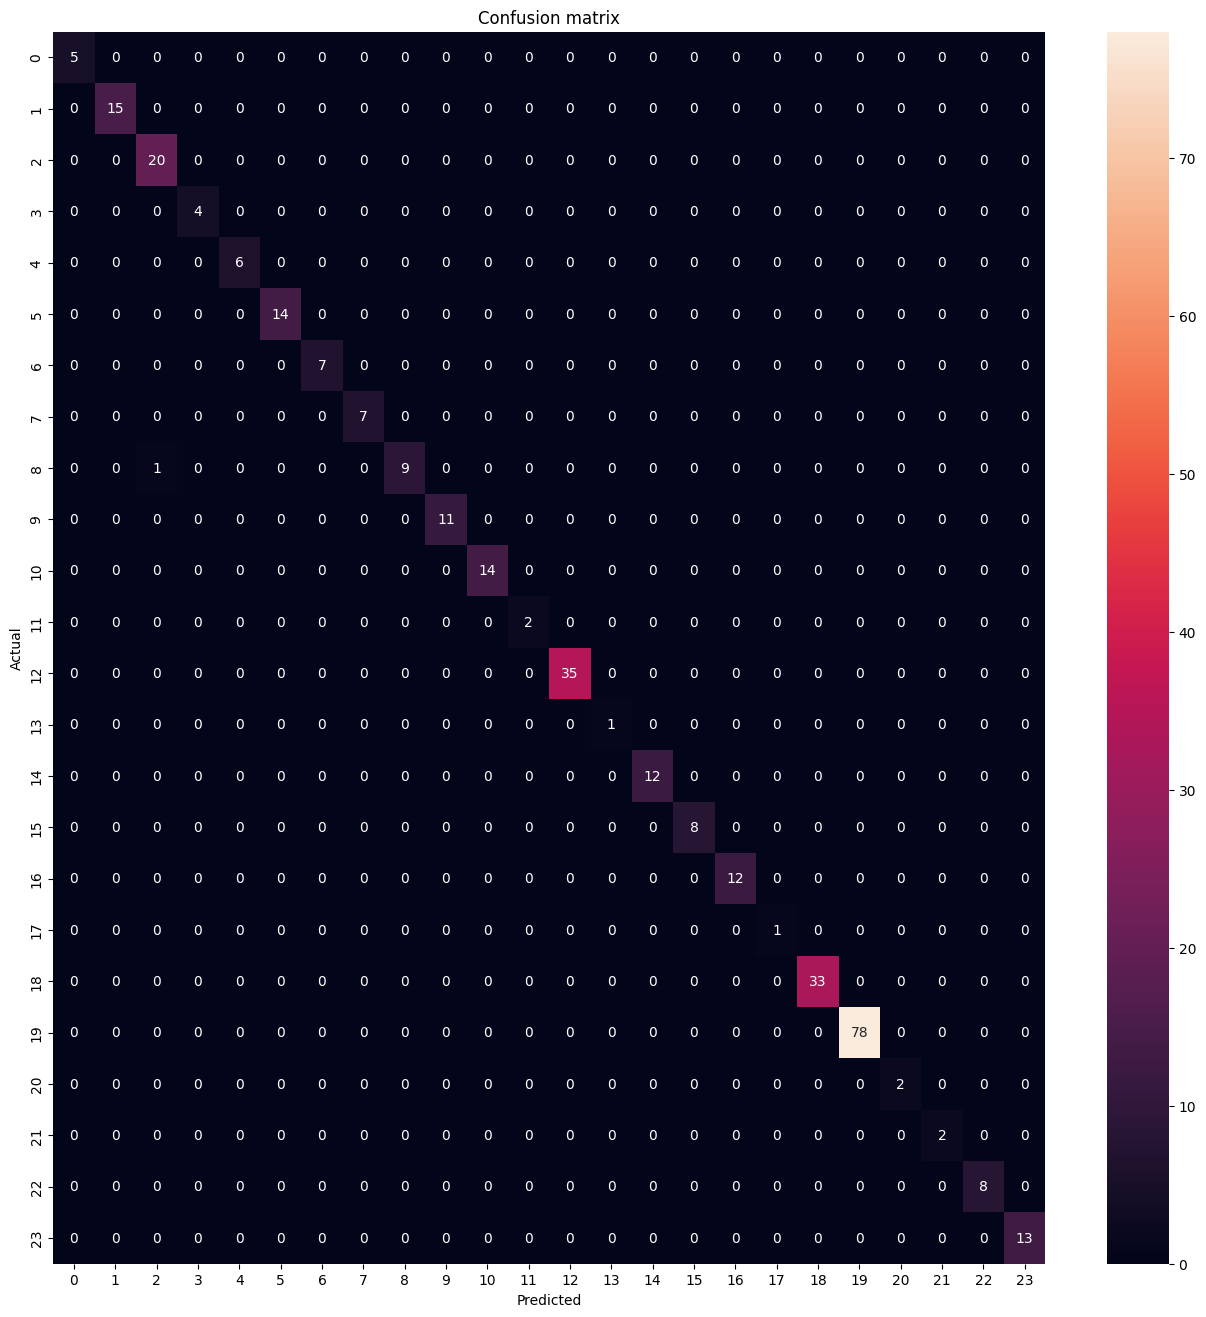

In [64]:
plt.figure(figsize = (16, 16))
sns.heatmap(cm, annot = True)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# **TESTING**

In [65]:
inputs = tokenizer(["Please how do i go about the account creation? ",
                    "After setting up my account, i feel like i need to change it. How do i go about that?",
                    "how do i know how much i need to pay?",
                    "purchased a product, which i now want to change"
                    ], padding = True, return_tensors = "tf")

logits = model(**inputs).logits
outputs = tf.argmax(logits, axis = -1).numpy()

In [66]:
print(outputs)

[14 12  7 16]


In [67]:
reverse_dict_intents = {i : intents[i] for i in range(len(intents))}
print(reverse_dict_intents)

{0: 'check_cancellation_fee', 1: 'get_invoice', 2: 'get_refund', 3: 'track_refund', 4: 'delete_account', 5: 'contact_human_agent', 6: 'set_up_shipping_address', 7: 'check_payment_methods', 8: 'switch_account', 9: 'check_refund_policy', 10: 'check_invoices', 11: 'recover_password', 12: 'edit_account', 13: 'delivery_period', 14: 'create_account', 15: 'newsletter_subscription', 16: 'change_order', 17: 'review', 18: 'complaint', 19: 'place_order', 20: 'contact_customer_service', 21: 'cancel_order', 22: 'payment_issue', 23: 'change_shipping_address', 24: 'registration_problems', 25: 'delivery_options', 26: 'track_order'}


In [68]:
for i in outputs:
  print(reverse_dict_intents[i])

create_account
edit_account
check_payment_methods
change_order
